<a href="https://colab.research.google.com/github/SandeepSagarMadanu/Road_Accidents_Prediction-Kaggle-Competition-/blob/main/road_accident(predictions)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("GPU Devices:", tf.config.list_physical_devices('GPU'))


GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import joblib


In [ ]:
lgbm = LGBMRegressor(device='gpu')


# load the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv(r'/content/drive/MyDrive/Data science files /Kaggle data sets/Different Road accidents prediction datasets/train.csv')
test = pd.read_csv(r'/content/drive/MyDrive/Data science files /Kaggle data sets/Different Road accidents prediction datasets/test.csv')
sample_submission = pd.read_csv(r'/content/drive/MyDrive/Data science files /Kaggle data sets/Different Road accidents prediction datasets/sample_submission.csv')


# EDA

In [ ]:
print(train.head())

   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           

In [ ]:
# Check data info
train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [ ]:
print(train.isnull().sum())

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


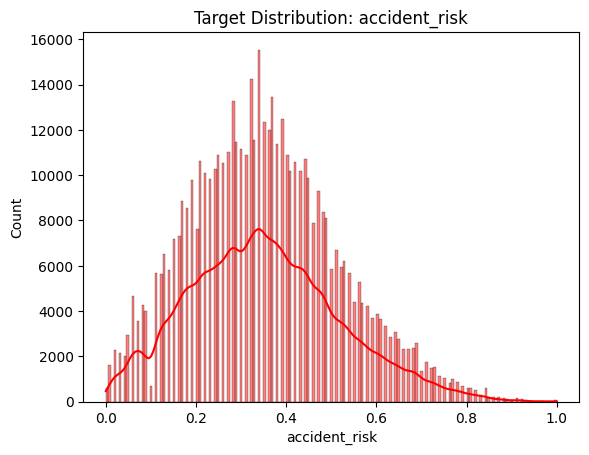

In [ ]:
# Target distribution
sns.histplot(train['accident_risk'], kde=True, color='red')
plt.title('Target Distribution: accident_risk')
plt.show()



In [ ]:
# Missing values
missing = train.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])


Series([], dtype: int64)


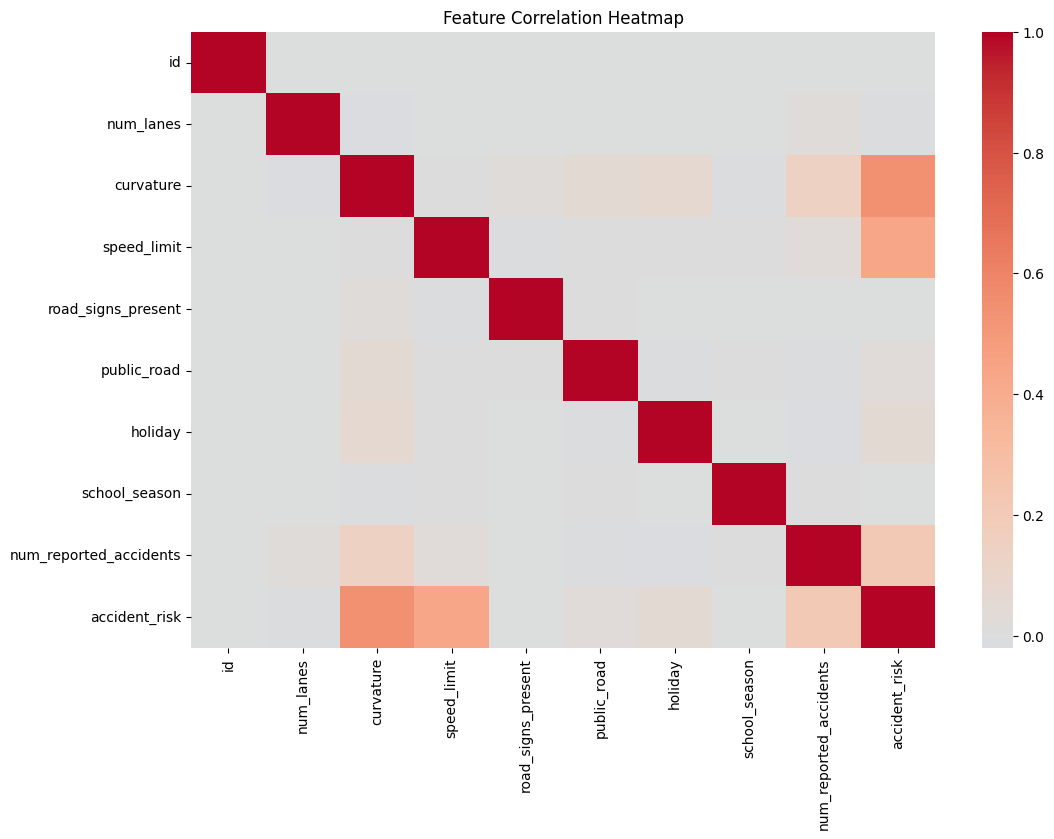

In [ ]:
# Correlations
corr = train.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

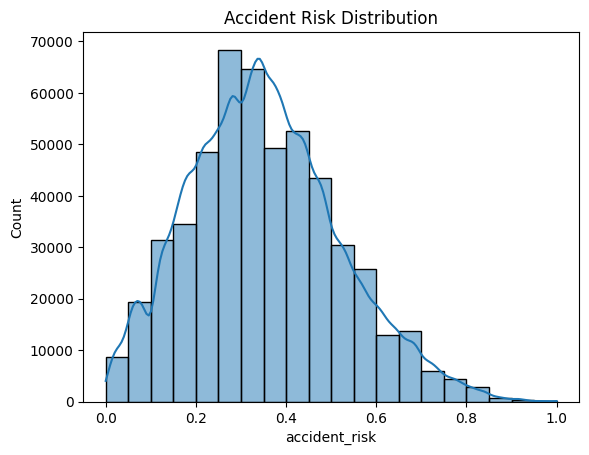

In [ ]:
sns.histplot(train['accident_risk'], bins=20, kde=True)
plt.title('Accident Risk Distribution')
plt.show()

# Merge one-hot with numeric

In [ ]:
numeric_features = [col for col in train.columns if col not in categorical_features + ['id', 'accident_risk']]
X_num = train[numeric_features].reset_index(drop=True)
X_test_num = test[numeric_features].reset_index(drop=True)

In [ ]:
categorical_features = train.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
X = X_num
X_test = X_test_num
y = train['accident_risk']

# Feature Engineering

In [ ]:
# Example feature construction
train['speed_curvature_ratio'] = train['speed_limit'] / (train['curvature'] + 1e-3)
test['speed_curvature_ratio'] = test['speed_limit'] / (test['curvature'] + 1e-3)


In [ ]:
# Encode categorical variables
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [ ]:
# Align columns between train and test
train, test = train.align(test, join='left', axis=1, fill_value=0)

# Prepare data for modeling

In [ ]:
X = train.drop(['accident_risk', 'id'], axis=1)
y = train['accident_risk']

X_test = test.drop(['id', 'accident_risk'], axis=1, errors='ignore') # Drop 'id' and 'accident_risk' from test set here


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Check and correct for inconsistent sample numbers before scaling
if len(X_train) != len(y_train):
    print(f"Warning: Inconsistent sample numbers in X_train ({len(X_train)}) and y_train ({len(y_train)}). Aligning X_train to y_train.")
    X_train = X_train.head(len(y_train))

if len(X_valid) != len(y_valid):
     print(f"Warning: Inconsistent sample numbers in X_valid ({len(X_valid)}) and y_valid ({len(y_valid)}). Aligning X_valid to y_valid.")
     X_valid = X_valid.head(len(y_valid))


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test) # Use the modified X_test

# 5. Model Training

In [ ]:
import xgboost as xgb
print(xgb.__version__)

3.1.0


In [ ]:
import xgboost as xgb

# K-Fold Cross-Validation with XGBoost
kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(test))

# Determine device for XGBoost
device = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'
print(f"Using device: {device}")


for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    # create copies to avoid SettingWithCopyWarning
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Ensure any remaining object/category columns are numeric and aligned between train/val/test
    obj_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    for c in obj_cols:
        # build categories from combined train+test to keep mappings consistent
        combined = pd.Categorical(pd.concat([X_train[c], X_test[c]], axis=0))
        X_train[c] = pd.Categorical(X_train[c], categories=combined.categories).codes
        X_val[c] = pd.Categorical(X_val[c], categories=combined.categories).codes
        X_test[c] = pd.Categorical(X_test[c], categories=combined.categories).codes

    # optional debug output (keeps types/numeric conversion visible)
    if obj_cols:
        print("Object/category columns converted to codes:", obj_cols)
        for c in obj_cols:
            print(f"  {c} -> train unique codes: {pd.Series(X_train[c].unique())[:10].tolist()}")

    # train and predict
    # Configure XGBoost parameters
    xgb_params = {
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': 7,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.005,
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist', # Use hist for faster training
        'device': device, # Use GPU if available
        'eval_metric': 'rmse' # Add eval_metric here
    }

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False) # Set verbose to True to see training progress

    oof_predictions[val_idx] = model.predict(X_val)
    test_predictions += model.predict(X_test) / kf.n_splits

    # mean_squared_error in some sklearn versions does not accept `squared` argument.
    # compute RMSE explicitly to avoid TypeError.
    rmse = np.sqrt(mean_squared_error(y_val, oof_predictions[val_idx]))
    print(f'Fold {fold+1} RMSE:', rmse)


overall_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
print(f'\n📊 Overall OOF RMSE: {overall_rmse:.4f}')

Using device: cuda


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [06:55:55] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Fold 1 RMSE: 0.05642366830521312
Fold 2 RMSE: 0.05627362273772785
Fold 3 RMSE: 0.05631137773838404
Fold 4 RMSE: 0.05615721888716319
Fold 5 RMSE: 0.056083971802313816

📊 Overall OOF RMSE: 0.0563


In [ ]:
import lightgbm as lgb

In [ ]:
# LightGBM with fine-tuning
lgbm = LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.02,
    max_depth=8,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Check shapes before fitting
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid_scaled:", X_valid_scaled.shape)
print("Shape of y_valid:", y_valid.shape)


lgbm.fit(X_train_scaled, y_train,
         eval_set=[(X_valid_scaled, y_valid)],
         eval_metric='rmse',
         callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False), lgb.log_evaluation(period=100)]) # Use callbacks with log_evaluation and early_stopping

pred_valid_lgbm = lgbm.predict(X_valid_scaled)
rmse_lgbm = np.sqrt(mean_squared_error(y_valid, pred_valid_lgbm)) # Calculate RMSE explicitly
print('LightGBM RMSE:', rmse_lgbm)

Shape of X_train_scaled: (414203, 17)
Shape of y_train: (414203,)
Shape of X_valid_scaled: (103551, 17)
Shape of y_valid: (103551,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 17
[LightGBM] [Info] Start training from score 0.352605
[100]	valid_0's rmse: 0.06301	valid_0's l2: 0.00397026
[200]	valid_0's rmse: 0.0567714	valid_0's l2: 0.003223
[300]	valid_0's rmse: 0.0564131	valid_0's l2: 0.00318244
[400]	valid_0's rmse: 0.0563352	valid_0's l2: 0.00317365
[500]	valid_0's rmse: 0.0563076	valid_0's l2: 0.00317055
[600]	valid_0's rmse: 0.0562942	valid_0's l2: 0.00316904
[700]	valid_0's rmse: 0.056284	valid_0's l2: 0.00316789
[800]	valid_0's rmse: 0.0562772	valid_0's l2: 0.00316712
[900]	valid

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM RMSE: 0.05627362383832426


# FEATURE IMPORTANCE

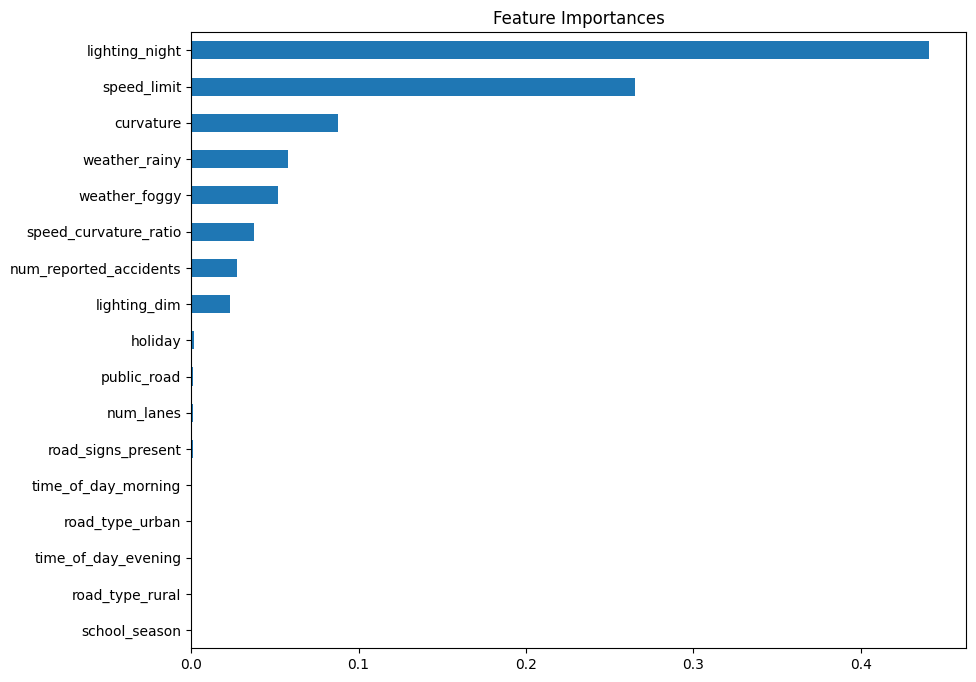

In [ ]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10,8))
plt.title('Feature Importances')
plt.show()

# predictions

In [ ]:
submission = sample_submission.copy() # Use the loaded sample_submission
final_preds = lgbm.predict(X_test_scaled)
submission['accident_risk'] = np.clip(final_preds, 0, 1)
submission.to_csv('submission.csv', index=False)
submission.head()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,id,accident_risk
0,517754,0.291633
1,517755,0.122057
2,517756,0.185640
3,517757,0.318989
4,517758,0.410337


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['accident_risk'].plot(kind='hist', bins=20, title='accident_risk')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='id', y='accident_risk', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['accident_risk']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('accident_risk')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['accident_risk'].plot(kind='line', figsize=(8, 4), title='accident_risk')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['accident_risk'].plot(kind='hist', bins=20, title='accident_risk')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='index', y='id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='id', y='accident_risk', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['accident_risk']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('accident_risk')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['accident_risk']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('accident_risk')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['accident_risk'].plot(kind='line', figsize=(8, 4), title='accident_risk')
plt.gca().spines[['top', 'right']].set_visible(False)

# Save model and upload

In [ ]:
joblib.dump(lgbm, 'lgbm_accident_model.pkl')


['lgbm_accident_model.pkl']

In [ ]:
# Display the first few rows of the submission file
print("First 5 rows of the submission file:")
display(submission.head())

# Get descriptive statistics of the predicted 'accident_risk'
print("\nDescriptive statistics of predicted accident_risk:")
display(submission['accident_risk'].describe())


First 5 rows of the submission file:


,id,accident_risk
0,517754,0.291633
1,517755,0.122057
2,517756,0.185640
3,517757,0.318989
4,517758,0.410337



Descriptive statistics of predicted accident_risk:


,accident_risk
count,172585.000000
mean,0.351710
std,0.156753
min,0.000000
25%,0.241723
50%,0.337110
75%,0.453710
max,0.883711


*The features are ranked by their importance in predicting accident risk, with the most important features at the top*

* lighting_night: This feature has the highest importance, suggesting that whether it is nighttime is the most significant factor influencing accident risk in this model.
* speed_limit: The speed limit is the second most important feature, which makes intuitive sense as higher speed limits or inappropriate speeds for conditions can increase risk.
* curvature: Road curvature is also a highly important feature, indicating that the (curvature) of the road plays a significant role in predicting accident risk.
* speed_curvature_ratio: The engineered feature combining speed and curvature also shows notable importance, highlighting the interaction between these two factors.
* weather_rainy and weather_foggy: These weather conditions are important predictors, as expected, as adverse weather increases accident risk.
Other features like lighting_dim, num_reported_accidents, road_type_rural, road_type_urban, public_road, holiday, road_signs_present, time_of_day_evening, time_of_day_morning, and num_lanes have lower importance in this specific model.
* In summary, the model suggests that lighting conditions (especially night), speed limit, and road curvature are the most influential factors in determining accident risk.